# lsstMicrolensYieldSimple #

** 2016-05-25 (WIC):** Predict the LSST microlensing yield per location on the sky. "Motivation" is written as might appear in WP chapter. 

**2016-07-13 (WIC):** This is a prototype figure of merit still under development, for a simple microlens yield. It illustrates the process of reading in pre-computed metrics (or re-running if not present) and evaluation of a derived quantity from these metrics.

(The formulae do not seem to render well on the online github notebook viewer. They look fine on a local machine though.)

** 2016-08-13 (WIC):** Added some syntax to make the final plots a little nicer / more presentable. 

# Motivation #

## Towards a metric ##

We expect the microlensing event rate to depend in some way on the surface density of lenses $s_{lens}$ and the surface density of background sources $s_{src}$. 

We might write the total number $N_{i,k}$ of microlensing events of a given type $k$ that LSST would observe in the $i$'th HEALPIX under a given strategy, as follows:
\begin{equation}
    N_{i,k} = K A R_k\left(s_{deep}, s_{shallow}\right) f_{obs}\left( t_i, \sigma_i, ... \right)
\end{equation}
where: 
* $A$ is the area in square degrees of the HEALPIX; 
* $K$ is a normalizing constant. This can be predicted through comparison to observation or more sophisticated modeling by microlensing experts. 
* $R_k(...)$ is a method to obtain the specific microlensing rate of a given type per year per square degree, where:
    * $s_{deep}$ is a density predicted from sims_maps, which can be related to the surface density of *lenses*;
    * $s_{shallow}$ is another density predicted from sims_maps, which can be related to the surface density of *sources*;
* $f_{obs}(...)$ is a method to obtain the fraction of microlens events actually observed in a given HEALPIX over the entire survey duration;
    * $t_i, \sigma_i, ...$ are the parameters on which the method depends.
    

We assume that $K$ takes the same value for all survey strategies chosen. Without knowing its value, then, strategies can be compared in a relative sense. However $K$ must be known if the Poisson floor is needed in a decision (e.g. if some type of microlensing event is simply too rare to provide adequate statistics under any strategy - although in that case, the relevant number would be the number of events summed over all the fields of interest). 


## Towards a Figure of Merit (FoM) ##

The outcome of this exercise should be a single number per strategy that allows quick comparison. At this time of writing, we take a simple approach: the total number of microlens events that LSST could detect, with the caveat that the overall normalization $K$ is not constrained. This leads to the following simple FoM to express LSST's sensitivity to stellar microlensing by the $k$'th population over the Region of Interest (RoI):
\begin{equation}
    F_{\mu,k} \equiv \sum^{\rm RoI}_{i=1} N_{i,k}
\end{equation}


## Implementing $N_{i,k}$ ##

In principle any level of sophistication could be brought to bear on the quantities $R_k(...)$ and $f_{obs}(...)$. For example, $f_{obs}$ might be the output of the **transientASCIIMetric** for a particular microlens-event type of interest. My first attempt was to go straight to Radek Poleski's (MNRAS 2016) published empirical microlensing rate from OGLE-III, but that may well not be applicable to the full Plane. Then I adopted a simpler method given below.

### The OGLE-III Empirical Microlensing Rate ###

Poleski (2016 MNRAS) shows an example empirical microlensing rate for the OGLE-III fields, using the surface density of Red Clump stars $s_{RC}$ as a proxy for $s_{lens}$, and the surface density $s_{I<I_0}$ of stars above some bright limit as a proxy for $s_{src}$. P16 defines a "Sensitivity" $S \equiv s_{RC}^{\alpha} s_{I < I_0}$ and fits the observed microlensing rate $\gamma$ as a function of this sensitivity. For the case of $I_0=20.5$, P16 reports $\alpha=0.55$ and reports the rate per year per square degree of events of duration longer than eight days, as 
\begin{equation}
    \gamma_{> 8d} = 0.767S_{0.55, 20.5} - 14.6
\end{equation}


To avoid this microlensing rate becoming negative at $S_{0.55, 20.5} \lesssim 19$, P16 taper their microlens rate smoothly but quickly to zero. Thanks to P16's releasing their Table 2 electronically, we can fit a power law to this tapering, finding $\gamma \approx 10^{-25} S^{19.1}$.

There is thus an extremely rapid drop-off for $S_{0.55, 20.5} \lesssim 20$ in P16's parameterization. 

Now $s_{RC}$ and $s_{I < 20.5}$ can both be reasonably well-fit as a function of $s_{i < 27.5}$ and $s_{i < 20.5}$ predicted by sims_maps. However when P16's model is used to predict the absolute microlensing rate calibrated to OGLE-III, the microlens rate drops off to zero almost immediately outside the OGLE-III footprint. This is perhaps not a surprise as it requires an extrapolation down to lower densities than OGLE-III seems to be capturing.

To reproduce that work, see **lsstMicrolensRate.ipynb**.

### An LSST microlensing rate ###

I adopt a simpler model:
\begin{eqnarray}
    R_k(...) & = & s^\alpha_{src} s^\beta_{lens} \propto s_{i < 20.5} s_{i < 27.5} \\
    f_{obs}(...) & = & T\\
\end{eqnarray}

where $s_{i < 20.5}$ is the surface density of sources with $i < 20.5$, $s_{i < 27.5}$ the surface density of sources with $i < 20.5$, and $T$ is the total duration (in years) of the observations in a given strategy towards a given sight-line.

Note that $s_{i < 20.5}$ probably leads to an *under*-prediction of microlens rates away from the bulge, as the crowding limit will be fainter than $i = 20.5$ for those fields. 

I estimate $K$ by finding the "optimal" scale factor that scales $R_k$ onto the $\gamma_k$ of P16. Under the assumption that LSST will perform about as well as OGLE-III, this yields an absolutely normalized microlens rate that is probably good to a factor $\sim$ few, at least in regions where LSST and OGLE-III overlap. The "metric" is then defined as 
\begin{equation}
    N_k = KTA s^\alpha_{i < 20.5} s^\beta_{i < 27.5}
\end{equation}

In practice, $\alpha$ and $\beta$ could be optimized to match observation, but for the moment I keep $\alpha = \beta =1$.

# Setup #

In [1]:
! ls -l healpy*py
! ls -l *db

-rw-r--r--  1 clarkson  staff  4606 Apr 23 12:12 healpyUtils.py
-rw-r--r--  1 clarkson  staff  4833732608 Apr 22 20:11 astro_lsst_01_1004_sqlite.db
-rw-r--r--  1 clarkson  staff  4906594304 Jan  4  2016 minion_1016_sqlite.db
-rw-r--r--  1 clarkson  staff  4933367808 Jan  6  2016 minion_1020_sqlite.db


In [2]:
import os, time

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.maps as maps

/Users/clarkson/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
# To create new bundle from the pre-loaded ones
import copy

In [5]:
# handy for display
from matplotlib.colors import LogNorm

In [6]:
# To compute pixel area
import healpy

In [7]:
# Needed for spatial coords
import numpy as np
import healpy as hp
import healpyUtils
from astropy.coordinates import SkyCoord

In [8]:
# home-grown routines
from surveyDurationMetric import PercentileRangeMetric
import microlensUtils

In [9]:
# To load P16 data
from astropy.io import ascii

# Choices #

In [458]:
# control variables common to both metrics
runName = 'minion_1016'
runName = 'astro_lsst_01_1004'  # wide-fast-deep including inner plane
nside = 64

In [459]:
# some control-flow variables
buildDensities = False   
buildDurations = False
plotIntermed = True

In [460]:
# exponents for the microlensing rate
alpha = 1.
beta = 1.

In [461]:
# control variables for density map
dirDens = 'starMap_test'

# magnitude limits for lens and source
magFaintLens = 27.5
magFaintSrc = 20.5
filtLens = 'i'
filtSrc = 'i'
tMaxDens = 365.25 * 3.

In [462]:
# control variables for duration-estimate
dirDuration = 'totalTime'
nYears = 10.  # total survey duration
filtDuration = 'i'
pctile = 100. 

histLoLim = 0.
histHiLim = None

In [463]:
# constructed variables common to both metrics 
opsimrun = '%s_sqlite.db' % (runName)

# Build the metrics $s_{i < 20.5}$, $s_{i < 27.5}$ and $\tau$ #

## Compute total survey duration in each sight-line $\tau$ ## 

In [464]:
# intermediate variables
tMaxDuration = np.float(nYears)*365.25

filDuration = '%s_Total_duration_night_lt_%i_and_%s_HEAL.npz' % (runName, tMaxDuration, filtDuration)

print filDuration, os.access('%s/%s' % (dirDuration, filDuration), os.R_OK)

astro_lsst_01_1004_Total_duration_night_lt_3652_and_i_HEAL.npz True


In [465]:
# construct metric name
sMetricName = 'Total duration'
if abs(pctile % 100.) > 1e-2:
    sMetricName = '%.1fth percentile duration' % (pctile)

In [466]:
# Describe the metric, the slicer, and the plot dictionary
sqlDuration = 'night < %i and filter = "%s"' % (tMaxDuration, filtDuration) # See How well we do after year 3
slicerDuration = slicers.HealpixSlicer(nside=nside, useCache=False)
metricDuration = PercentileRangeMetric('expMJD', pctile, metricName=sMetricName)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [467]:
# set up the metric bundle for the total duration
bundleDuration = metricBundles.MetricBundle(metricDuration, slicerDuration, sqlDuration, runName=runName)

# Yes there is a namespace collision... probably OK...
opsdb = db.OpsimDatabase(opsimrun)
resultsDb = db.ResultsDb(dirDuration)
bgroup = metricBundles.MetricBundleGroup({0: bundleDuration}, opsdb, outDir=dirDuration, resultsDb=resultsDb)

In [468]:
pathDuration = '%s/%s' % (dirDuration, filDuration)
hasDuration = os.access(pathDuration, os.R_OK)
print pathDuration, hasDuration

totalTime/astro_lsst_01_1004_Total_duration_night_lt_3652_and_i_HEAL.npz True


In [469]:
# now run this!
if not hasDuration or buildDurations:
    bgroup.runAll()
else:
    print "INFO - durations already present. Not rerunning."

INFO - durations already present. Not rerunning.


## Build $s_{lens}$ and $s_{src}$ ##

In [470]:
opsdb = db.OpsimDatabase(opsimrun)
resultsDb = db.ResultsDb(outDir=dirDens)

In [471]:
bundleList = []
sql = 'night < %i' % (tMaxDens) 
slicer = slicers.HealpixSlicer(nside=nside, useCache=False)

# Metrics
metricLens = metrics.StarDensityMetric(rmagLimit=magFaintLens, \
                                   metricName='%sMag < %.1f' % (filtLens, magFaintLens))

metricSrc = metrics.StarDensityMetric(rmagLimit=magFaintSrc, \
                                      metricName='%sMag < %.1f' % (filtSrc, magFaintSrc))

# Maps
mafMapLens = maps.StellarDensityMap(filtername=filtLens[:])
mafMapSrc = maps.StellarDensityMap(filtername=filtSrc[:])

plotDict = {'colorMin':0.001, 'colorMax':.1, 'logScale':True}

# Assemble the bundle from the metrics
bundle = metricBundles.MetricBundle(metricLens,\
                                    slicer,sql, \
                                    mapsList=[mafMapSrc], \
                                    plotDict=plotDict, \
                                   runName=runName)
bundleList.append(bundle)
bundle = metricBundles.MetricBundle(metricSrc, \
                                    slicer,sql, \
                                    mapsList=[mafMapSrc], \
                                    plotDict=plotDict, \
                                   runName=runName)
bundleList.append(bundle)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [472]:
# generate output filename WARN HARDCODE STILL!!
filDensSrc='%s_iMag_lt_20_5_night_lt_1095_HEAL.npz' % (runName)
filDensLens='%s_iMag_lt_27_5_night_lt_1095_HEAL.npz' % (runName)

In [473]:
# decision logic about whether to rerun
hasLens =  os.access('%s/%s' % (dirDens, filDensLens), os.R_OK)
hasSrc =  os.access('%s/%s' % (dirDens, filDensSrc), os.R_OK)
if buildDensities or not hasLens or not hasSrc:
    bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, \
                                             outDir=dirDens, \
                                             resultsDb=resultsDb)
    bgroup.runAll()
else:
    print "INFO - both starmaps already present. Not rebuilding."

INFO - both starmaps already present. Not rebuilding.


# Load the metric values #

## Load the duration information into memory ##

In [474]:
# However we obtained it, load the bundle for durations
bundleDuration = metricBundles.createEmptyMetricBundle()
bundleDuration.read(pathDuration)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Load the density starmaps into memory ##

In [475]:
# However we obtained it, load the bundle for lenses. 
pathLens = '%s/%s' % (dirDens, filDensLens)
bundleLens = metricBundles.createEmptyMetricBundle()
bundleLens.read(pathLens)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [476]:
# Import the bundle for sources
pathSrc = '%s/%s' % (dirDens, filDensSrc)
bundleSrc = metricBundles.createEmptyMetricBundle()
bundleSrc.read(pathSrc)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Find galactic coordinates for the fields ##

In [477]:
# Assuming all the metrics share the same HEALPIX scheme, just one set of coords is enough.
npix = bundleSrc.metricValues.size
nside = hp.npix2nside(npix)
ra, dec = healpyUtils.hpid2RaDec(nside, np.arange(npix))
cc = SkyCoord(ra=np.copy(ra), dec=np.copy(dec), frame='fk5', unit='deg')

In [478]:
# some minor adjustments to do here... Set up convenience views:
gL = np.copy(cc.galactic.l)
gB = np.copy(cc.galactic.b)

bHi = gL > 180.
gL[bHi] -= 360.

## Examine the maps of the metrics ##

monopole: 2641.95  dipole: lon: -97.7121, lat: -52.8181, amp: 466.771


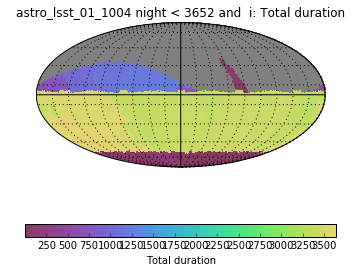

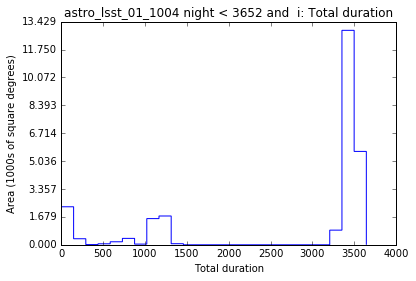

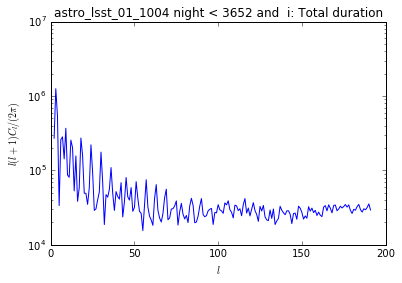

In [479]:
# Intermediate plot?
if plotIntermed:
    bundleDuration.setPlotDict({'xMin':histLoLim})
    bundleDuration.plot()

monopole: 0.00313717  dipole: lon: -100.388, lat: -7.6957, amp: 0.00491081
monopole: 0.0289183  dipole: lon: -98.0993, lat: -1.20808, amp: 0.0485002


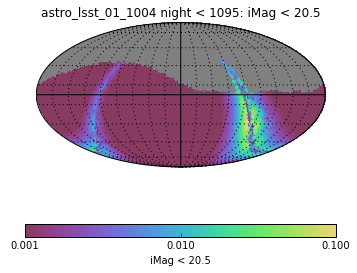

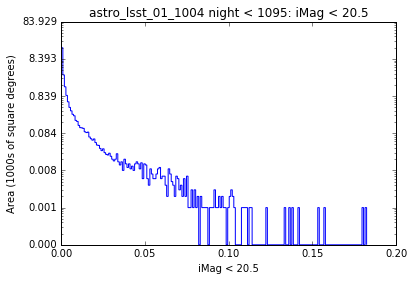

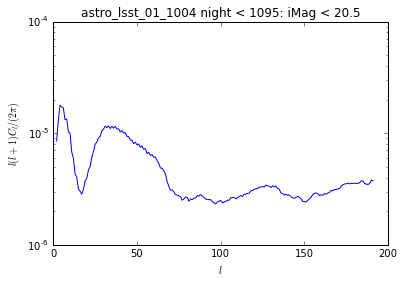

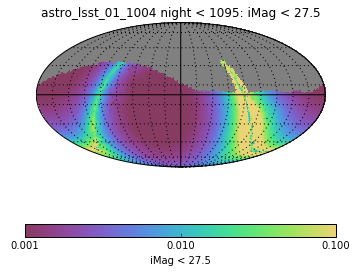

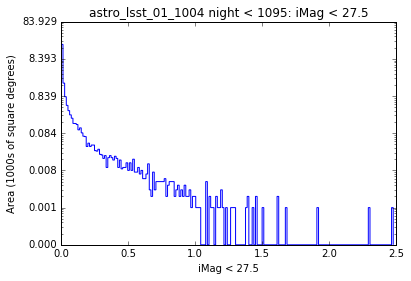

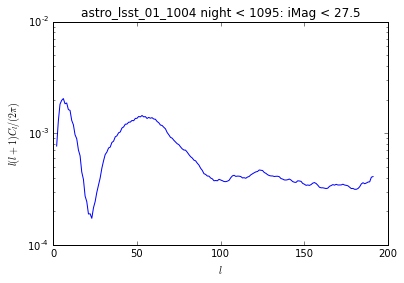

In [480]:
if plotIntermed:
    bundleSrc.plot()
    bundleLens.plot()

# Produce microlensing rate from the metrics #

## Microlensing rate R ##

In [481]:
# convenience views
nDeep = bundleLens.metricValues
nShallow = bundleSrc.metricValues

# non-empty entries
bGood = (~bundleLens.metricValues.mask) & (~bundleSrc.metricValues.mask) 
print np.sum(bGood)

31116


In [482]:
alpha=1.0
beta=1.0

In [483]:
# compute the rate
gammValues = nDeep**alpha * nShallow**beta

In [484]:
print np.min(gammValues)
print np.max(gammValues)

0.0
0.44520609


## Rate per HEALPIX per year $N_{i,k}$ ##

In [485]:
# produce the pixel area in square degrees
pixAreaSqDeg = healpy.pixelfunc.nside2pixarea(nside, degrees=True)
print "HEALPIX area %.3f sq deg" % (pixAreaSqDeg)

HEALPIX area 0.839 sq deg


In [486]:
# Number of microlens events per pixel
ratePerPixel = gammValues * pixAreaSqDeg

In [487]:
# Predicted number of microlens detections, assuming an OGLE-III-like recovery
numPerPixel = gammValues * pixAreaSqDeg * bundleDuration.metricValues/365.25

In [488]:
print np.min(ratePerPixel)
print np.max(ratePerPixel)

0.0
0.373658642146


In [489]:
print np.min(bundleDuration.metricValues)
print np.max(bundleDuration.metricValues)

1.10879999999
3644.119852


In [490]:
print np.min(numPerPixel)
print np.max(numPerPixel)

0.0
3.52305971471


## Cross-check with OGLE-III predictions ##

To attempt a value of $k$, we can find the scaling (or transformation?) that maps our predicted microlensing rate onto that reported by P16. We need to ensure that the right files are present:

In [491]:
! ls -l event_rates_*dat

-rw-r--r--  1 clarkson  staff  120717 May 17 17:58 event_rates_CDS.dat


In [492]:
r = ascii.get_reader(ascii.Cds)
tIn = r.read('event_rates_CDS.dat')
print tIn.colnames

['Name', 'l', 'b', 'N_RC', 'N_*(I<20)', 'N_*(I<20.5)', 'gam_1,20', 'gam_0.55,20.5']


### Naiive cross-match ###

In [493]:
def naiiveMatch(x1, y1, x2, y2, dMin=0.5):
    
    """Quick and rough matching between two sets of coordinates. Returns matching indices."""
    
    n1 = np.size(x1)
    n2 = np.size(x2)
    
    # arrays of matches
    l1 = []
    l2 = []
        
    for i1 in range(n1):
        xc = np.float(x1[i1])
        yc = np.float(y1[i1])
        d2 = np.sqrt( (x2 - xc)**2 + (y2 - yc)**2)
        if np.min(d2) > dMin:
            continue
        
        l1.append(i1)
        l2.append(np.argmin(d2))
    
    return np.asarray(l1, 'int'), np.asarray(l2, 'int')

In [494]:
# select OGLE-III fields for above minimum event rate
rateMin = 4.  # the lower limit reported by P16
bOGLE = (tIn['gam_0.55,20.5'] > rateMin)

In [495]:
# Looks like LSST less finely spatially-sampled, so cut down on that first
loL = np.min(tIn['l'])-0.1
hiL = np.max(tIn['l'])+0.1
loB = np.min(tIn['b'])-0.1
hiB = np.max(tIn['b'])+0.1
bReg = (gL >= loL) & (gL < hiL) & (gB >= loB) & (gB < hiB) 
gReg = np.where(bReg)[0]

In [496]:
# find the nearest matches
gLSST, gOGLE = naiiveMatch(gL[bReg], gB[bReg], tIn['l'][bOGLE], tIn['b'][bOGLE])

In [497]:
# get the indices we'll actually use:
gReg = np.where(bReg)[0]
gNonzer = np.where(bOGLE)[0]

# Get the indices we'll actually need
gSims = gReg[gLSST]
gObs = gNonzer[gOGLE]

### Find the scale factor taking LSST onto OGLE ###

We use the "golden rule:"
\begin{eqnarray}
    f & \equiv & \frac{R_{OGLE}}{R_{LSST}} \\
    & & \\
    \langle f \rangle  & = & \frac{\sum_i R_{OGLE, i}~R_{LSST, i}} {\sum_i R^2_{LSST, i} }
\end{eqnarray}

In [498]:
# some convenience views first
rOGLE = tIn['gam_0.55,20.5'][gObs]
rLSST = np.copy(ratePerPixel[gSims])
fScal = np.sum(rOGLE * rLSST)/np.sum(rLSST**2)
print "scale factor: %.2f" % (fScal)

scale factor: 145.32


(0.1, 100)

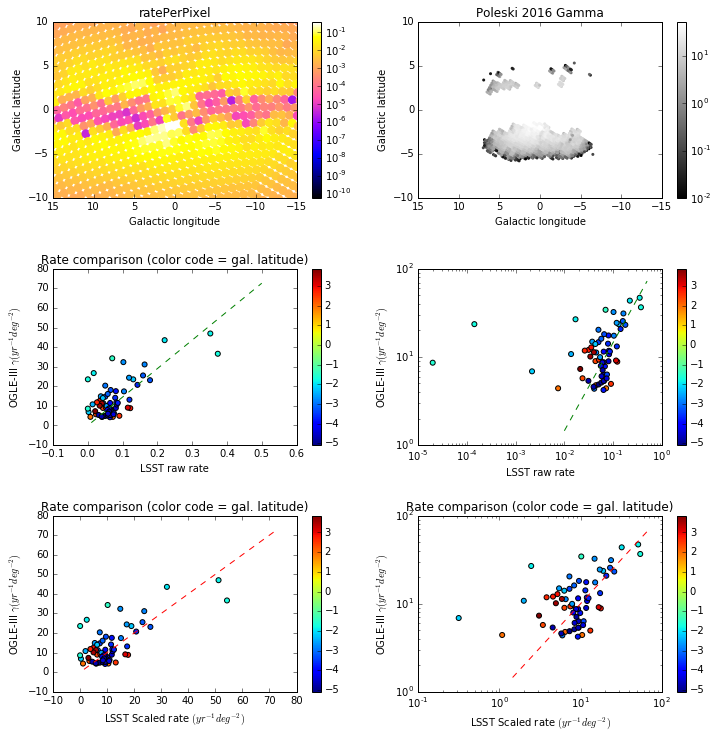

In [499]:
# make a plot
cMap2 = plt.cm.get_cmap('gnuplot2')
plt.figure(10, figsize=(12,12))
plt.clf()
plt.subplots_adjust(hspace=0.4)

plt.subplot(321)
plt.scatter(gL, gB, \
            c=ratePerPixel, \
            edgecolor='none', \
            s=81, \
           cmap=cMap2, norm=LogNorm())
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
plt.title('ratePerPixel')
plt.colorbar()
plt.xlim(15., -15.)
plt.ylim(-10., 10.)

plt.subplot(322)
plt.scatter(tIn['l'], tIn['b'], \
            c=tIn['gam_0.55,20.5'], \
            edgecolor='none', s=9, \
           cmap=plt.cm.get_cmap('gray'), \
            norm=LogNorm())
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
plt.title('Poleski 2016 Gamma')
plt.colorbar()
plt.xlim(15., -15.)
plt.ylim(-10., 10.)

xFine = np.linspace(1e-2,5e-1, 100, endpoint=True)
yFine = xFine * fScal

# SOme standard labels
sOGLE = r'OGLE-III $\gamma (yr^{-1} deg^{-2})$'
sLSST = r'LSST Scaled rate $(yr^{-1} deg^{-2})$'

plt.subplot(323)
plt.scatter(ratePerPixel[gSims], \
            tIn['gam_0.55,20.5'][gObs], \
           c=tIn['b'][gObs], s=25)
plt.plot(xFine, yFine, 'g--')
plt.colorbar()
plt.xlabel('LSST raw rate')
plt.ylabel(sOGLE)
plt.title('Rate comparison (color code = gal. latitude)')

plt.subplot(324)
plt.loglog(ratePerPixel[gSims], tIn['gam_0.55,20.5'][gObs], 'w.', zorder=1)
plt.scatter(ratePerPixel[gSims], tIn['gam_0.55,20.5'][gObs], zorder=2, \
            c=tIn['b'][gObs], s=25)
plt.colorbar()
plt.plot(xFine, yFine, 'g--')
plt.xlabel('LSST raw rate')
plt.ylabel(sOGLE)

xFineScal = xFine * fScal

plt.subplot(325)
plt.scatter(ratePerPixel[gSims] * fScal, \
            tIn['gam_0.55,20.5'][gObs], \
           c=tIn['b'][gObs], s=25)
plt.plot(xFineScal, xFineScal, 'r--')
plt.colorbar()
plt.xlabel(sLSST)
plt.ylabel(sOGLE)
plt.title('Rate comparison (color code = gal. latitude)')

plt.subplot(326)
plt.loglog(ratePerPixel[gSims], tIn['gam_0.55,20.5'][gObs], 'w.', zorder=1)
plt.scatter(ratePerPixel[gSims] * fScal, \
            tIn['gam_0.55,20.5'][gObs], \
           c=tIn['b'][gObs], s=25)
plt.plot(xFineScal, xFineScal, 'r--')
plt.colorbar()
plt.xlabel(sLSST)
plt.ylabel(sOGLE)
plt.title('Rate comparison (color code = gal. latitude)')

plt.xlim(1e-1, 100)




### Use this to re-scale the LSST predictions ###

In [500]:
rateScaled = ratePerPixel * fScal
numScaled = numPerPixel * fScal

## Scatterplot the values ##

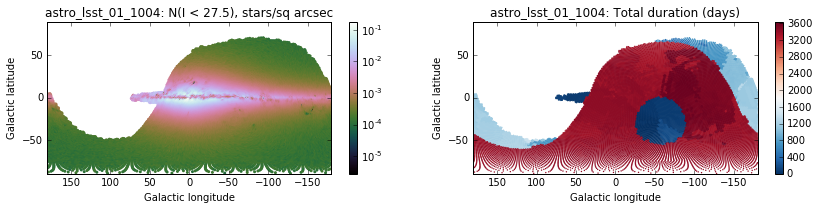

In [501]:
# here it is in scatterplot form
cMap = plt.cm.get_cmap('RdBu_r')
plt.figure(4,figsize=(14,6))
plt.clf()

plt.subplot(222)
plt.scatter(gL[bGood], gB[bGood], c=bundleDuration.metricValues[bGood], \
            edgecolor='none', s=2, cmap=cMap, vmin=0.)
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
sTitle = '%s: %s (days)' % (runName, bundleDuration.metric.name)
plt.title(sTitle)
plt.xlim(180., -180.)
plt.ylim(-90., 90.)
plt.colorbar()

plt.subplot(221)
plt.scatter(gL, gB, c=bundleSrc.metricValues, \
            edgecolor='none', s=9, \
            #cmap=cMap, \
            cmap=plt.cm.get_cmap('cubehelix'), \
            norm=LogNorm()\
           )
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
sTitle = '%s: %s' % (runName, 'N(I < 27.5), stars/sq arcsec')
plt.title(sTitle)
plt.xlim(180., -180.)
plt.ylim(-90., 90.)
plt.colorbar()


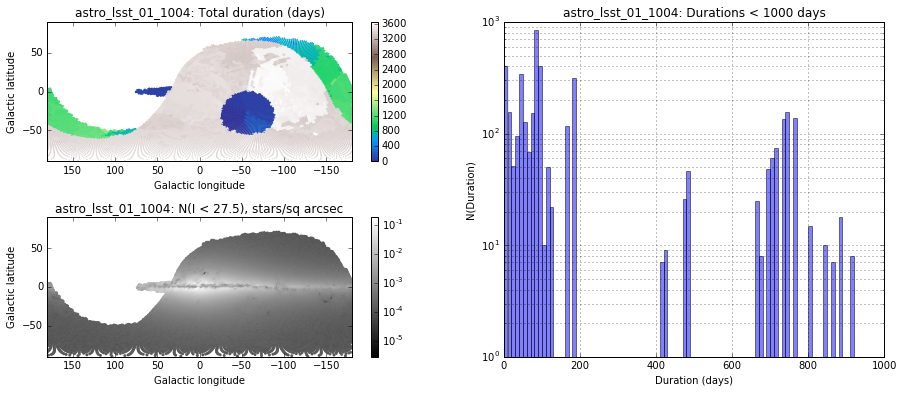

In [502]:
# Figure for whitepaper: density and duration
cMap = plt.cm.get_cmap('terrain')
cMapDens = plt.cm.get_cmap('gray')
plt.figure(12, figsize=(15,6))
plt.clf()

plt.subplots_adjust(hspace=0.4)

plt.subplot(221)
plt.scatter(gL[bGood], gB[bGood], c=bundleDuration.metricValues[bGood], \
            edgecolor='none', s=2, cmap=cMap, vmin=0.)
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
sTitle = '%s: %s (days)' % (runName, bundleDuration.metric.name)
plt.title(sTitle)
plt.xlim(180., -180.)
plt.ylim(-90., 90.)
plt.colorbar()

plt.subplot(223)
plt.scatter(gL, gB, c=bundleSrc.metricValues, \
            edgecolor='none', s=9, \
            cmap=cMapDens, \
            norm=LogNorm()\
           )
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
sTitle = '%s: %s' % (runName, 'N(I < 27.5), stars/sq arcsec')
plt.title(sTitle)
plt.xlim(180., -180.)
plt.ylim(-90., 90.)
plt.colorbar()

plt.subplot(122)
dum = plt.hist(bundleDuration.metricValues[bGood], bins=100, range=(0, 1000), log=True,  alpha=0.5)
plt.grid(which='both')
plt.xlabel('Duration (days)')
plt.ylabel('N(Duration)')
plt.title(r'%s: Durations < 1000 days' % (runName))
figName = '%s_durations.png' % (runName)
plt.savefig(figName)

In [503]:
! pwd

/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411


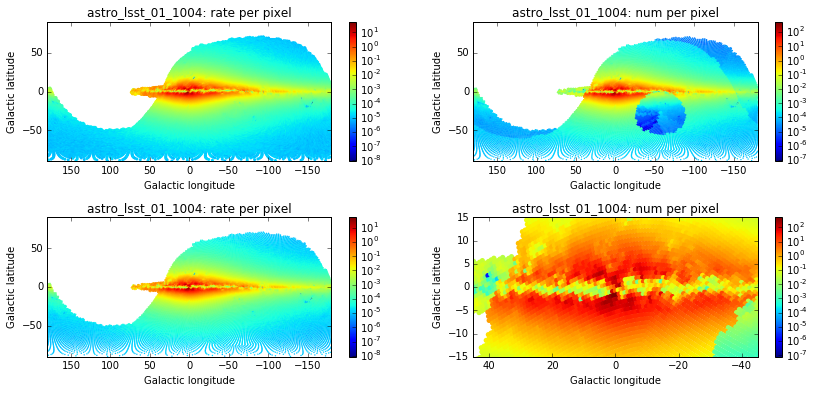

In [504]:

# Another scatterplot, this time showing the intermediate densities nRC and nSrc
cMap = plt.cm.get_cmap('jet')
plt.figure(4,figsize=(14,6))
plt.clf()

plt.subplots_adjust(hspace=0.4)

plt.subplot(222)
plt.scatter(gL, gB, \
            c=numScaled, \
            #c=np.asarray(bundleSrc.metricValues, 'float')* 3.10, \
            edgecolor='none', s=2, \
            cmap=cMap, \
            norm=LogNorm())
    #, \
            #vmin=0., vmax=5. )
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
sTitle = '%s: num per pixel' % (runName)
plt.title(sTitle)
plt.xlim(180., -180.)
plt.ylim(-90., 90.)
plt.colorbar()

plt.subplot(221)
plt.scatter(gL, gB, \
            c=rateScaled, \
            edgecolor='none', s=9, \
            #cmap=cMap, \
            cmap=cMap, \
            norm=LogNorm()\
           )
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
sTitle = '%s: rate per pixel' % (runName)
plt.title(sTitle)
plt.xlim(180., -180.)
plt.ylim(-90., 90.)
plt.colorbar()

plt.subplot(223)
plt.scatter(gL, gB, \
            c=rateScaled, \
            #c=bundleSrc.metricValues * bundleLens3600.**2 / 1.0e6, \
            edgecolor='none', s=2, \
            cmap=cMap, \
            norm=LogNorm() )
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
sTitle = '%s: rate per pixel' % (runName)
plt.title(sTitle)
plt.xlim(180., -180.)
plt.ylim(-90., 90.)
plt.colorbar()

plt.subplot(224)
plt.scatter(gL, gB, \
            c=numScaled, \
            edgecolor='none', s=26, \
            cmap=cMap, \
            #vmin=10)
            norm=LogNorm() )
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
sTitle = '%s: num per pixel' % (runName)
plt.title(sTitle)
plt.xlim(45., -45.)
plt.ylim(-15., 15.)
plt.colorbar()



In [505]:
# build some bulge regions
bulgeWidth = 10.
bulgeHeight = 3.
lBulgeN = bulgeWidth * 0.5 * np.array([-1., 1., 1., -1.])
bBulgeN = np.array([4., 4., 4. + bulgeHeight, 4. + bulgeHeight])

lRegs = []
bRegs = []
for iReg in range(-3,8):
    lRegs.append(lBulgeN - bulgeWidth * (np.float(iReg)+0.5) )
    bRegs.append(bBulgeN - 1.)

diskWidth=30.
lDiskNeg = -90. + 0.5 * diskWidth * np.array([1., -1., -1., 1.])
bDiskNeg = np.array([-8., -8., 8., 8.])

# 2016-08-13 for the moment, don't use the big region
#lRegs.append(lDiskNeg)
#bRegs.append(bDiskNeg)



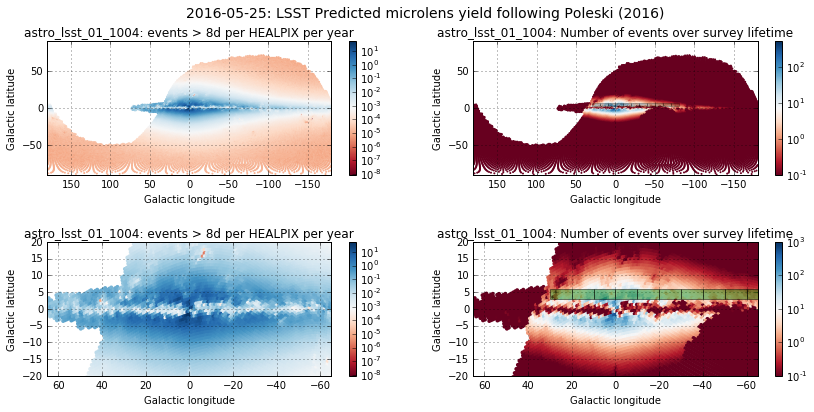

In [506]:
# Show the combined metric in scatterplot form
cMap = plt.cm.get_cmap('gist_ncar_r')

cMap = plt.cm.get_cmap('RdBu')
plt.figure(5,figsize=(14,6))
plt.clf()

#cutoffNum = 1e-2
cutoffNum = 0.1

plt.subplots_adjust(hspace=0.5)

plt.suptitle('2016-05-25: LSST Predicted microlens yield following Poleski (2016)', \
             fontsize=14)

plt.subplot(221)
plt.scatter(gL, gB, c=rateScaled, \
            edgecolor='none', s=4, cmap=cMap, \
           norm=LogNorm(), \
            #vmin=1e-2\
           )
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
sTitle = '%s: %s' % (runName, 'events > 8d per HEALPIX per year')
plt.title(sTitle)
plt.xlim(180., -180.)
plt.ylim(-90., 90.)
plt.grid(which='both')
plt.colorbar()

plt.subplot(222)
plt.scatter(gL, gB, c=numScaled, \
            edgecolor='none', s=4, \
            cmap=cMap, \
            norm=LogNorm(), vmin=cutoffNum)
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
sTitle = '%s: %s' % (runName, 'Number of events over survey lifetime')
plt.title(sTitle)
plt.xlim(180., -180.)
plt.ylim(-90., 90.)
plt.grid(which='both')
plt.colorbar()


for iReg in range(len(lRegs)):
    plt.fill(lRegs[iReg], bRegs[iReg], 'k', alpha=0.25, zorder=20)


plt.subplot(223)
plt.scatter(gL, gB, c=rateScaled, \
            edgecolor='none', s=16, cmap=cMap, \
           norm=LogNorm(), \
            #vmin=1e-2\
           )
plt.grid(which='both')
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
sTitle = '%s: %s' % (runName, 'events > 8d per HEALPIX per year')
plt.title(sTitle)
plt.xlim(65., -65.)
plt.ylim(-20., 20.)
plt.colorbar()

plt.subplot(224)
plt.scatter(gL, gB, c=numScaled, \
            edgecolor='none', s=16, \
            cmap=cMap, \
            norm=LogNorm(), \
            vmin=cutoffNum, vmax=1e3)
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
sTitle = '%s: %s' % (runName, 'Number of events over survey lifetime')
plt.title(sTitle)
plt.xlim(90., -90.)  # was 65
plt.ylim(-30., 30.)  # was 20
plt.xlim(65., -65.)
plt.ylim(-20., 20.)
plt.grid(which='both')
plt.colorbar()

# 2016-08-13 Silence the regions for the moment
for iReg in range(len(lRegs)):
    plt.fill(lRegs[iReg], bRegs[iReg], 'g', alpha=0.45, zorder=20)

plt.savefig('2016-05-25_microlensYieldSimpleScaling_cutoff.png')

In [507]:
! pwd
! ls -rtl *png | tail -3

/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411
-rw-r--r--  1 clarkson  staff  157348 Aug 13 18:13 TEST_microlens_minion_1016.png
-rw-r--r--  1 clarkson  staff  120258 Aug 13 18:14 astro_lsst_01_1004_durations.png
-rw-r--r--  1 clarkson  staff  223039 Aug 13 18:14 2016-05-25_microlensYieldSimpleScaling_cutoff.png


## Estimate figure of merit from these predictions ##

In [508]:
def inRect(x,y,xRect, yRect):
    """Convenience method - points inside rectangle"""
    
    bIn = (x >= np.min(xRect)) & (x < np.max(xRect)) & \
    (y >= np.min(yRect)) & (y < np.max(yRect))
    
    return bIn

In [509]:
# return the amounts
numFound= []
areaSrch = []
lCen = []
bCen = []

rates = []
ratesErr = []
for iReg in range(len(lRegs)):
    bThis = inRect(gL, gB, lRegs[iReg], bRegs[iReg])
    
    # compute the number of events and the total area on the sky
    nThis = np.sum(numScaled[bThis])
    areaThis = np.sum(bThis)*pixAreaSqDeg

    # average duration
    durThis = np.mean(bundleDuration.metricValues[bThis])
    
    lCen.append(np.mean(lRegs[iReg]))
    bCen.append(np.mean(bRegs[iReg]))
    numFound.append(nThis)
    areaSrch.append(areaThis)
    
    # poisson error on the inferred rate
    thisRate = np.float(nThis)*365.25 / durThis
    thisRateErr = np.sqrt(np.float(nThis))*365.25 / durThis
    
    rates.append(thisRate)
    ratesErr.append(thisRateErr)
    
    print "[%6.2f, %6.2f]: %6.2f, %5i -- %6.1f, %.1f %.1f pm %.2f" % \
        (lCen[-1], bCen[-1], areaThis, nThis, 100./np.sqrt(np.float(nThis)), durThis, thisRate, thisRateErr)
    
# convert to arrays
lCen = np.asarray(lCen)
bCen = np.asarray(bCen)
numFound = np.asarray(numFound)
areaSrch = np.asarray(areaSrch)

[ 25.00,   4.50]:  31.05,   119 --    9.1, 3453.7 12.7 pm 1.16
[ 15.00,   4.50]:  29.38,   479 --    4.6, 3462.5 50.5 pm 2.31
[  5.00,   4.50]:  30.21,  1163 --    2.9, 3460.8 122.8 pm 3.60
[ -5.00,   4.50]:  30.21,  1333 --    2.7, 3440.1 141.5 pm 3.88
[-15.00,   4.50]:  31.05,   649 --    3.9, 3441.6 69.0 pm 2.71
[-25.00,   4.50]:  28.54,   164 --    7.8, 3435.8 17.4 pm 1.36
[-35.00,   4.50]:  30.21,   191 --    7.2, 3443.7 20.3 pm 1.47
[-45.00,   4.50]:  28.54,    75 --   11.5, 3414.4 8.1 pm 0.93
[-55.00,   4.50]:  31.05,    44 --   14.9, 3501.3 4.7 pm 0.70
[-65.00,   4.50]:  29.38,    25 --   19.8, 3585.3 2.6 pm 0.51
[-75.00,   4.50]:  30.21,    14 --   26.5, 3611.8 1.4 pm 0.38


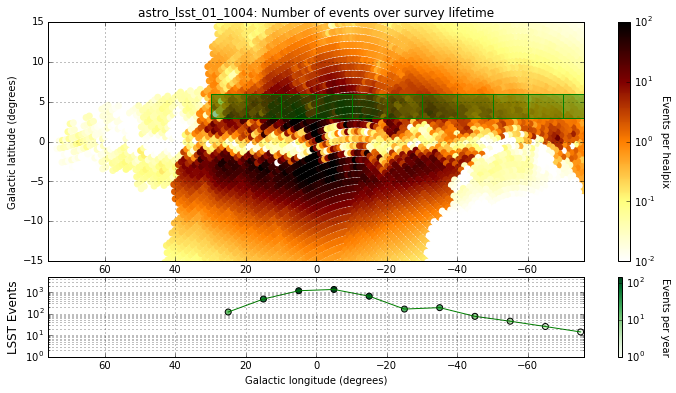

In [510]:
# Try one more figure, this time with microlens rates overplotted
cMap = plt.cm.get_cmap('RdBu') 
cMap = plt.cm.get_cmap('afmhot_r') 
#cMap = plt.cm.get_cmap('RdYlBu_r') 



fig = plt.figure(6,figsize=(12,6))
fig.clf()

import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2,1, height_ratios=[6.,2], hspace=0.1)

#cutoffNum = 1e-2
cutoffNum = 0.01
ax1 = plt.subplot(gs[0])
#ax1=plt.subplot(211)

cax = ax1.scatter(gL, gB, c=numScaled, \
            edgecolor='none', s=49, \
            cmap=cMap, \
            norm=LogNorm(), \
            vmin=cutoffNum, vmax=1e2)  # vmax was 1e3
#ax1.set_xlabel('Galactic longitude')
ax1.set_ylabel('Galactic latitude (degrees)')
sTitle = '%s: %s' % (runName, 'Number of events over survey lifetime')
ax1.set_title(sTitle)
ax1.set_xlim(65., -65.)  # was 65
ax1.set_ylim(-15., 15.)  # was 20
ax1.grid(which='both')
cbar = fig.colorbar(cax)

# 2016-08-13 Silence the regions for the moment
for iReg in range(len(lRegs)):
    ax1.fill(lRegs[iReg], bRegs[iReg], 'g', alpha=0.45, zorder=20)
    ax1.plot(lRegs[iReg], bRegs[iReg], 'g', zorder=21)
    
ax1.annotate('Events per healpix', (1.15,0.5), xycoords='axes fraction', rotation=270, \
            ha='center', va='center')
    
ax2 = plt.subplot(gs[1], sharex=ax1)


    
#ax2=plt.subplot(212, sharex=ax1)
    
#plt.subplot(122)
#plt.errorbar(lCen, rates/areaSrch, yerr=ratesErr/areaSrch)
cax2 = ax2.scatter(lCen, numFound, s=36, c=rates, cmap=plt.cm.get_cmap('Greens'), \
                    norm=LogNorm(), vmin=1)
ax2.plot(lCen, numFound, color='g')
ax2.set_yscale('log')
ax2.set_ylabel('LSST Events', fontsize=12)

ax2.annotate('Events per year', (1.15,0.5), xycoords='axes fraction', rotation=270, \
            ha='center', va='center')

cbar2 = fig.colorbar(cax2)

ax2.set_ylim(1e0, 5e3)
#plt.xlim(65,-65)
plt.xlim(76., -76.)
plt.grid(which='both')

ax2.set_xlabel('Galactic longitude (degrees)')

figName = 'TEST_microlens_%s.png' % (runName)
plt.savefig(figName)

In [511]:
! pwd

/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411
